# Collaborative Filtering recommender

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [25]:
DATA_DIR = "../botify/data/large/"
DATA_PATH = "../botify/data/"

In [5]:
# https://drive.google.com/drive/folders/1Nz5ZD3HKyCfncdF368Tym5ktjyFCd5Li?usp=sharing
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

In [6]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [7]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [8]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [9]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(47057, 16492)

In [10]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [11]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [12]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [13]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2022-08-04 17:33:47,695] A new study created in memory with name: no-name-34f763a8-8327-40ea-9431-6590c710c35d
[I 2022-08-04 17:34:10,757] Trial 0 finished with value: 0.007065669167786837 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 10, 'user_alpha': 0.0, 'item_alpha': 0.0}. Best is trial 0 with value: 0.007065669167786837.
[I 2022-08-04 17:34:24,967] Trial 1 finished with value: 0.0009559434838593006 and parameters: {'loss': 'bpr', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.007065669167786837.
[I 2022-08-04 17:34:53,920] Trial 2 finished with value: 0.008520365692675114 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0, 'item_alpha': 0.0}. Best is trial 2 with value: 0.008520365692675114.
[I 2022-08-04 17:35:24,135] Trial 3 finished with value: 0.0006511498941108584 and parameters:

[I 2022-08-04 17:46:31,418] Trial 29 finished with value: 0.0075644226744771 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.0}. Best is trial 2 with value: 0.008520365692675114.


In [14]:
best_params

{'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 50,
 'user_alpha': 0.0,
 'item_alpha': 0.0}

In [16]:
best_params = {'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 50,
 'user_alpha': 0.0,
 'item_alpha': 0.0}

In [17]:
model, precisions_at = fit_model(
    epochs=100,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.0063591026701033115 +/- 0.0006482387116924927
1:	0.006719312630593777 +/- 0.0006764086716667313
2:	0.0068717096000909805 +/- 0.0006869591822618538
3:	0.007301191799342632 +/- 0.0007115357592913988
4:	0.007896924391388893 +/- 0.000748146428540327
5:	0.009129953570663929 +/- 0.0008141584842256645
6:	0.010820171795785427 +/- 0.000890166764644536
7:	0.012704350054264069 +/- 0.0009525994030340686
8:	0.014574674889445305 +/- 0.0010156114654531893
9:	0.016195621341466904 +/- 0.001071784485154639
10:	0.01781656965613365 +/- 0.0011232564525839928
11:	0.0193682461977005 +/- 0.001160187902045089
12:	0.02062898315489292 +/- 0.001188634338896098
13:	0.0220559723675251 +/- 0.0012195738804155027
14:	0.02351066656410694 +/- 0.001248011894905951
15:	0.024702133610844612 +/- 0.0012715841913810977
16:	0.026059851050376892 +/- 0.0013048595628767966
17:	0.027362151071429253 +/- 0.0013277689851988413
18:	0.028415074571967125 +/- 0.0013458658019425895
19:	0.02935716137290001 +/- 0.0013618571144886392
20

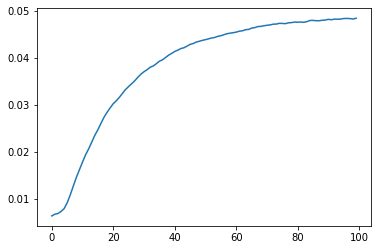

In [21]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [22]:
biases, embeddings = model.get_item_representations()

In [23]:
model.item_biases *= 0.0

In [26]:
track_meta = pd.read_json(DATA_PATH + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [27]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [28]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [29]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [30]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████| 8874/8874 [00:14<00:00, 604.95it/s]
